In [1]:
from haversine import haversine_vector, Unit
import os
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

import cmdstanpy
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.31.0
Install directory: /Users/andrea/.cmdstan
CmdStan version 2.31.0 already installed


True

In [2]:
import pandas as pd

source = "../house12latlong.csv"
df = pd.read_csv(source, index_col=0)
df['Latitude'] = df['Latitude'].str.replace(',', '.').astype(float)
df['Longitude'] = df['Longitude'].str.replace(',', '.').astype(float)
df

,price,Overall.Qual,Garage.Area,Total.Bsmt.SF,X1st.Flr.SF,Full.Bath,AgeofHouse,Mas.Vnr.Area,TotRms.AbvGrd,Fireplaces,Wood.Deck.SF,Open.Porch.SF,Longitude,Latitude
1,215000,6,528.0,1080.0,1656,1,50,112.0,7,2,210,62,-93.619754,42.054035
2,149900,6,452.0,1178.0,1293,2,52,28.0,5,0,280,0,-93.618462,42.053406
3,157500,6,313.0,1008.0,1024,1,50,244.0,5,2,0,0,-93.618182,42.053327
4,124500,6,502.0,882.0,882,1,53,0.0,5,0,0,0,-93.618895,42.053036
5,169000,5,963.0,1617.0,1797,1,49,302.0,7,1,0,0,-93.619262,42.053108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,170000,5,418.0,1389.0,1389,1,31,0.0,6,1,240,38,-93.600190,41.990921
2916,285000,8,482.0,1679.0,1803,2,15,0.0,6,2,129,64,-93.600006,41.989848
2917,188000,7,650.0,996.0,996,2,12,94.0,9,1,190,48,-93.599996,41.989265
2918,231000,6,616.0,1152.0,1152,2,16,0.0,7,1,162,312,-93.600147,41.989185


In [18]:
stan_model = CmdStanModel(stan_file="./marginal-spatial-phi.stan")

16:54:59 - cmdstanpy - INFO - compiling stan file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-phi.stan to exe file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-phi
INFO:cmdstanpy:compiling stan file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-phi.stan to exe file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-phi
DEBUG:cmdstanpy:cmd: make /tmp/tmpf9mq2hhd/tmpvb8pdixu
cwd: /Users/andrea/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmpf9mq2hhd/tmpvb8pdixu.hpp /tmp/tmpf9mq2hhd/tm

In [7]:
indexes = df.index.copy().to_numpy()
np.random.shuffle(indexes)
small_df = df.loc[indexes[:100], :]

coords = small_df.loc[:, ["Latitude", "Longitude"]]
dists = haversine_vector(coords, coords, Unit.KILOMETERS, comb=True)

In [19]:

features = small_df.loc[:, ["Overall.Qual", "Garage.Area", "Total.Bsmt.SF", "X1st.Flr.SF",
                "Mas.Vnr.Area", "TotRms.AbvGrd", "Fireplaces",
                "Wood.Deck.SF", "Full.Bath"]]
                
data = {
    "N": small_df.shape[0],
    "p": features.shape[1],
    "Y": small_df.loc[:, "price"],
    "X": features,
    "dist": dists,
    # "phi": 0.8,
    "priorsigma2": [2,1],
    "priortau2": [2,1]
}

stan_fit = stan_model.sample(data=data, chains=4, 
                             parallel_chains=4, 
                             iter_warmup=1000, iter_sampling=5000)

cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzlqh2kaz/ji_tbw4u.json
DEBUG:cmdstanpy:cmd: /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-phi info
cwd: None
16:57:40 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-phi', 'id=1', 'random', 'seed=59742', 'data', 'file=/tmp/tmpzlqh2kaz/ji_tbw4u.json', 'output', 'file=/tmp/tmpzlqh2kaz/marginal-spatial-phih9kdx0on/marginal-spatial-phi-20221217165741_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-phi', 'id=2', 'random', 'seed=59742', 'data', 'file=/tmp/t

17:04:45 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-phi', 'id=1', 'random', 'seed=59742', 'data', 'file=/tmp/tmpzlqh2kaz/ji_tbw4u.json', 'output', 'file=/tmp/tmpzlqh2kaz/marginal-spatial-phih9kdx0on/marginal-spatial-phi-20221217165741_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpzlqh2kaz/marginal-spatial-phih9kdx0on/marginal-spatial-phi-20221217165741_1.csv
 console_msgs (if any):
	/tmp/tmpzlqh2kaz/marginal-spatial-phih9kdx0on/marginal-spatial-phi-20221217165741_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    

In [9]:
print(stan_fit.diagnose())

DEBUG:cmdstanpy:cmd: /Users/andrea/.cmdstan/cmdstan-2.31.0/bin/diagnose /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_1.csv /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_2.csv /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_3.csv /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_4.csv
cwd: None


Processing csv files: /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_1.csv, /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_2.csv, /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_3.csv, /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_4.csv

Checking sampler transitions treedepth.
2 of 20000 (0.01%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
2284 of 20000 (11.42%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - samp

In [10]:
stan_fit.summary()

DEBUG:cmdstanpy:cmd: /Users/andrea/.cmdstan/cmdstan-2.31.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpzlqh2kaz/stansummary-marginal-spatial-phi-r8tw056y.csv /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_1.csv /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_2.csv /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_3.csv /tmp/tmpzlqh2kaz/marginal-spatial-phijgnjq3m4/marginal-spatial-phi-20221217164439_4.csv
cwd: None


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-6.129980e+06,7.506920e+06,1.063310e+07,-2.655310e+07,-1.169290e+03,-1.158110e+03,2.00631,0.003134,26.44360
beta0,4.215530e+03,4.503990e+03,1.187640e+04,-1.353130e+04,1.292610e+00,2.681280e+04,6.95306,0.010861,1.17124
beta[1],1.023820e+03,4.529910e+02,1.028510e+03,-1.054990e+02,9.490040e+02,2.817490e+03,5.15512,0.008053,1.25035
beta[2],5.894140e+01,2.467620e+01,3.792540e+01,1.507670e+00,6.854780e+01,1.105300e+02,2.36213,0.003690,2.42529
beta[3],5.902110e+01,3.235300e+01,5.041340e+01,5.694500e-01,6.063170e+01,1.378780e+02,2.42808,0.003793,2.26595
beta[4],-3.339200e+00,1.172310e+01,2.879520e+01,-5.399150e+01,-5.380250e-01,4.692490e+01,6.03334,0.009425,1.20600
beta[5],8.360370e+01,3.926510e+01,5.950340e+01,4.652580e-01,9.685790e+01,1.653480e+02,2.29651,0.003587,2.63107
beta[6],7.428720e+02,3.714620e+02,9.661010e+02,-4.952310e+02,5.571350e+02,2.482860e+03,6.76420,0.010566,1.17408
beta[7],5.353850e+02,2.347440e+02,9.129410e+02,-7.734570e+02,2.893920e+02,2.200840e+03,15.12500,0.023627,1.07191
beta[8],1.008980e+02,4.370890e+01,6.720930e+01,-1.740870e+00,1.189300e+02,1.904460e+02,2.36440,0.003693,2.41536


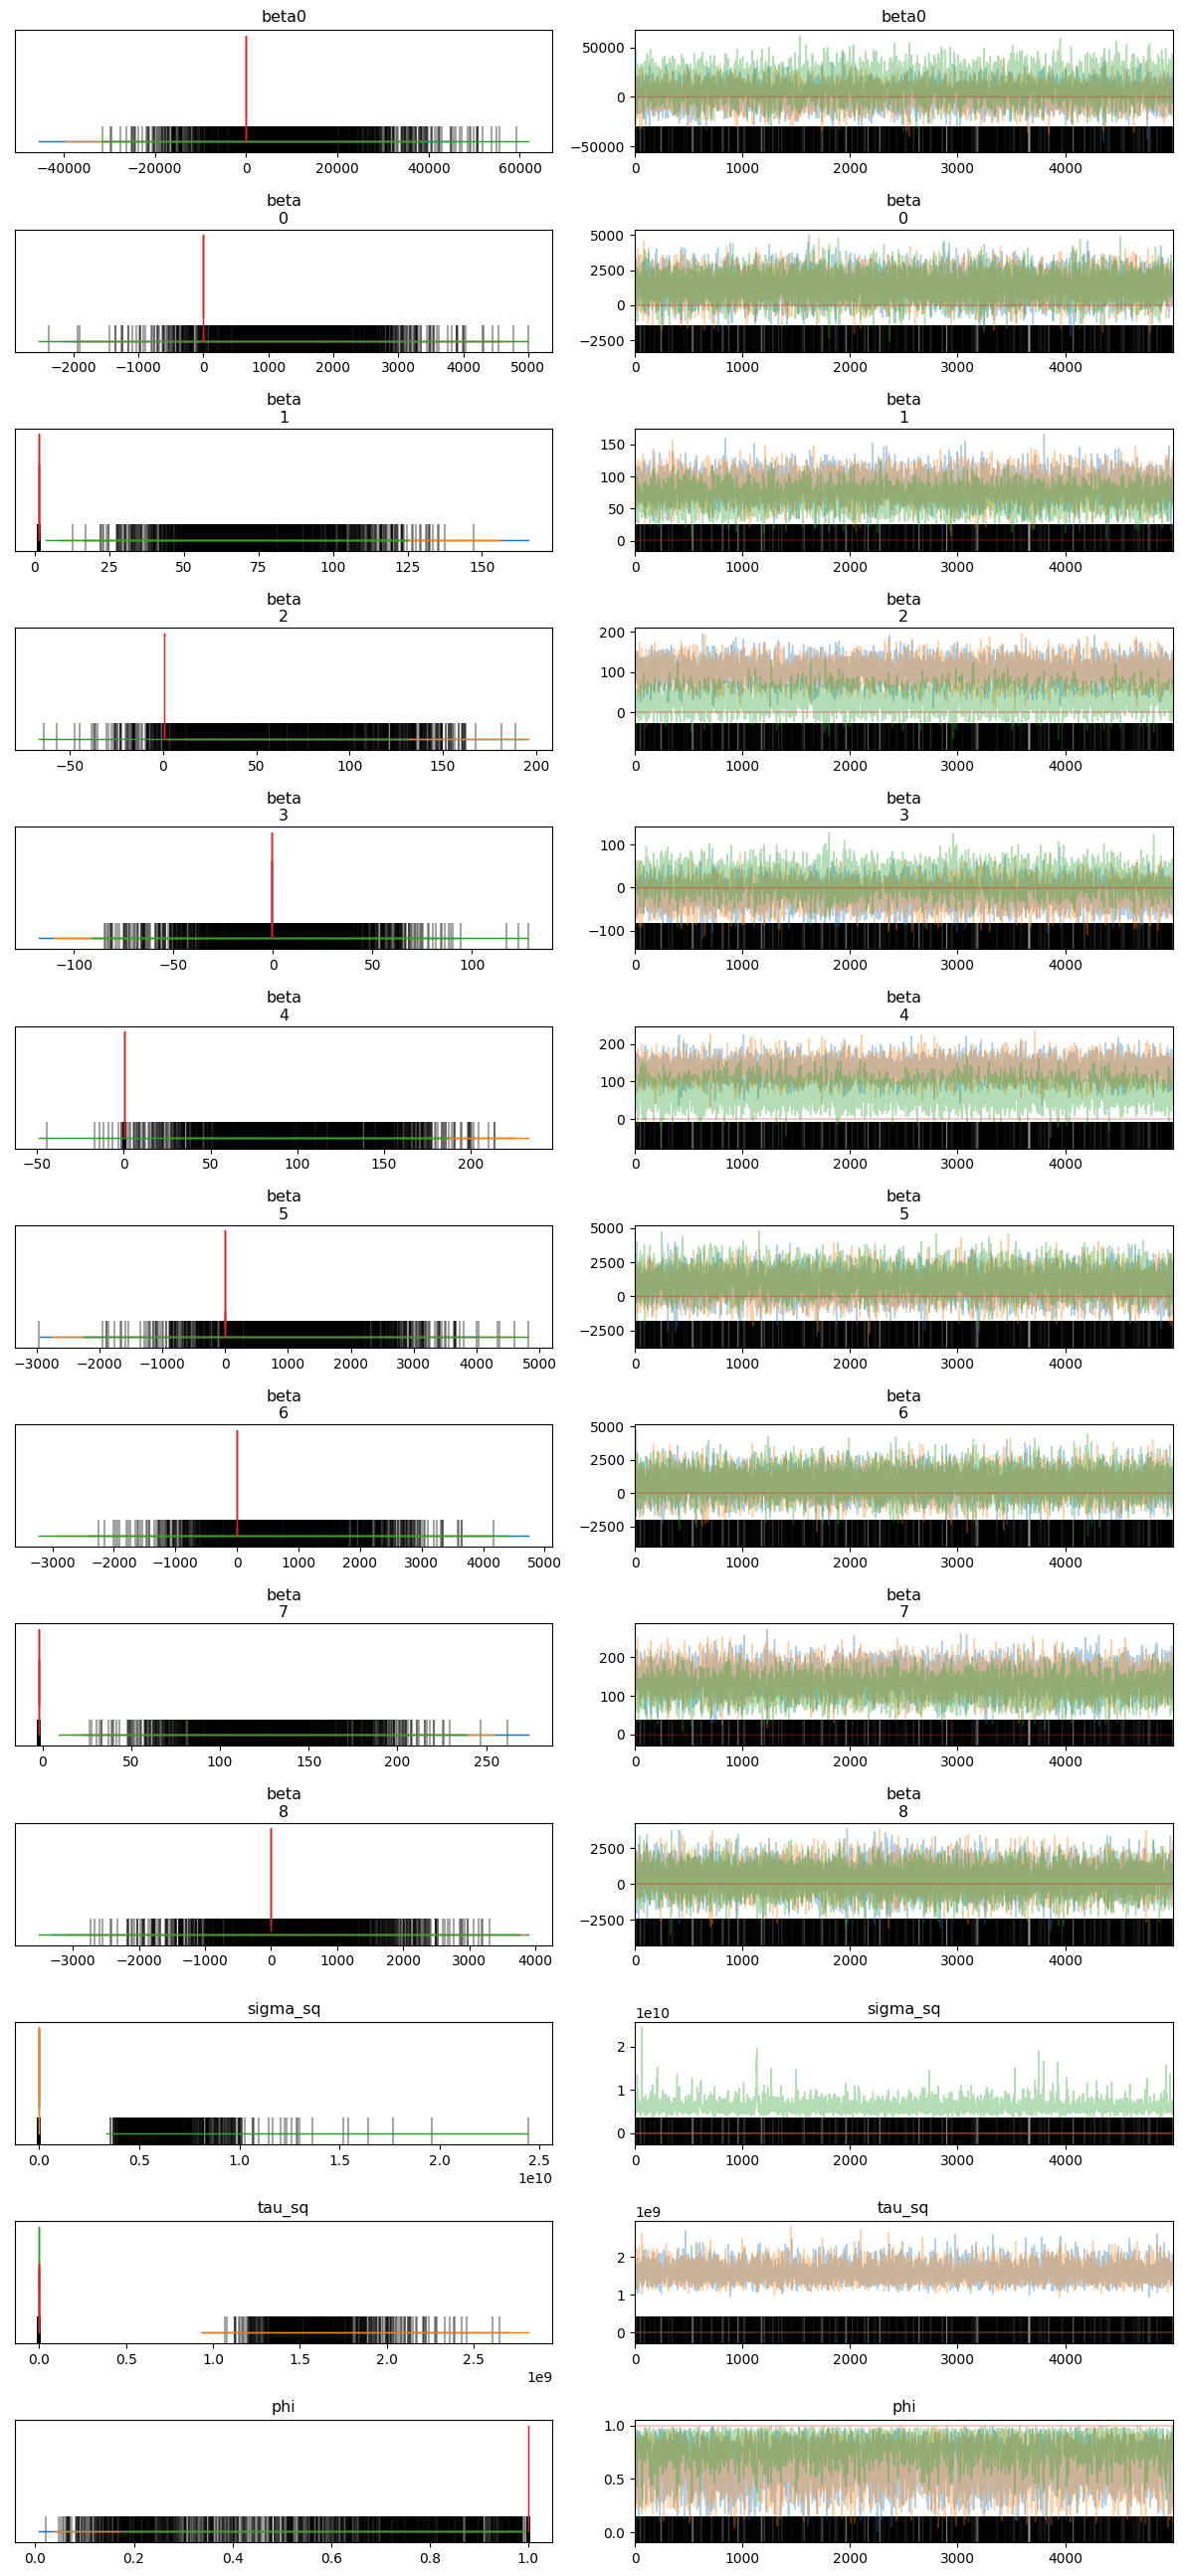

In [11]:
cmdstanpy_data = az.from_cmdstanpy(stan_fit)
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
# plt.savefig("ssvs-bsts.png")
plt.show()